In [ ]:
import scanpy as sc
import decoupler as dc

# Only needed for processing and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import liana as li

## Any X,Y combo

#### Pre-process

In [ ]:
adata = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata.var_names_make_unique()
adata

In [ ]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=10)

# Annotate the group of mitochondrial genes as 'mt'
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Filter cells following standard QC criteria.
adata = adata[adata.obs.pct_counts_mt < 20, :]

# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Identify highly variable genes
sc.pp.highly_variable_genes(adata)

# Filter higly variable genes
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

# Scale the data
sc.pp.scale(adata, max_value=10)

In [ ]:
# Generate PCA features
sc.tl.pca(adata, svd_solver='arpack')

# Compute distances in the PCA space, and find spot neighbors
sc.pp.neighbors(adata)

# Run leiden clustering algorithm
sc.tl.leiden(adata)

# Visualize
sc.pl.spatial(adata, color=[None, 'leiden'], size=1.5, wspace=0)

In [ ]:
adata.write_h5ad("processed_visium.h5ad")

In [ ]:
model = dc.get_progeny(organism='human', top=1000)
model

In [ ]:
dc.run_mlm(mat=adata, net=model, source='source', target='target', weight='weight', verbose=True)

# Store them in a different key
adata.obsm['progeny_mlm_estimate'] = adata.obsm['mlm_estimate'].copy()
adata.obsm['progeny_mlm_pvals'] = adata.obsm['mlm_pvals'].copy()

In [ ]:
acts = dc.get_acts(adata, obsm_key='progeny_mlm_estimate')
acts

In [ ]:
acts.write_h5ad('progeny_acts.h5ad')

In [ ]:
model = dc.get_dorothea(organism='human')

In [ ]:
dc.run_mlm(mat=adata, net=model, source='source', target='target', weight='weight', verbose=True)

# Store them in a different key
adata.obsm['dorothea_mlm_estimate'] = adata.obsm['mlm_estimate'].copy()
adata.obsm['dorothea_mlm_pvals'] = adata.obsm['mlm_pvals'].copy()

In [ ]:
acts = dc.get_acts(adata, obsm_key='dorothea_mlm_estimate')
acts

In [ ]:
acts.write_h5ad('dorothea_acts.h5ad')

In [ ]:
acts

## X & Y

In [55]:
import liana as li
import scanpy as sc
import pandas as pd
import numpy as np

In [56]:
from mudata import MuData

In [57]:
from liana.utils._utils import _get_props
from scipy.sparse import csr_matrix
from itertools import product, combinations

In [58]:
adata = sc.read_h5ad("processed_visium.h5ad")

In [59]:
li.mt.get_spatial_proximity(adata=adata, parameter=200, bypass_diagonal=True, cutoff=0.1)

In [60]:
progeny = sc.read_h5ad('progeny_acts.h5ad')

In [61]:
dorothea = sc.read_h5ad('dorothea_acts.h5ad')

In [62]:
mdata = MuData({"expr": adata, 'progeny': progeny, 'dorothea': dorothea})

/home/dbdimitrov/anaconda3/envs/liana-py/lib/python3.10/site-packages/mudata/_core/mudata.py:458: UserWarning: Cannot join columns with the same name because var_names are intersecting.


In [63]:
def _anndata_to_stats(adata, nz_thr=0.1):
    adata.X = csr_matrix(adata.X)
    global_stats = pd.DataFrame({'means': adata.X.mean(axis=0).A.flatten(),
                                 'non_zero': _get_props(adata.X)},
                                index=adata.var_names)
    global_stats = global_stats.reset_index().rename(columns={'index': 'entity'})
    global_stats = global_stats[global_stats['non_zero'] >= nz_thr]

    return global_stats

In [64]:
from liana.method._global_lr_pipe import _global_lr_pipe, _rename_means

In [78]:
x_stats = _rename_means(_anndata_to_stats(progeny), entity='x')
y_stats = _rename_means(_anndata_to_stats(dorothea), entity='y')

In [79]:
xy_dataframe = pd.DataFrame(list(product(x_stats['x_entity'], y_stats['y_entity'])), columns=['x_entity', 'y_entity'])

In [80]:
# for one df
# xy_dataframe = pd.DataFrame(list(combinations(adata.var.index, 2)), columns=['x_entity', 'y_entity'])

In [103]:
# join global stats to LRs from resource
xy_res = xy_dataframe.merge(x_stats).merge(y_stats)

In [104]:
xy_res

,x_entity,y_entity,x_means,x_non_zero,y_means,y_non_zero
0,Androgen,AHR,1.055404,1.0,-0.134946,1.0
1,EGFR,AHR,0.913506,1.0,-0.134946,1.0
2,Estrogen,AHR,-2.512781,1.0,-0.134946,1.0
3,Hypoxia,AHR,1.044591,1.0,-0.134946,1.0
4,JAK-STAT,AHR,6.993168,1.0,-0.134946,1.0
...,...,...,...,...,...,...
4111,TNFa,ZNF740,5.252833,1.0,0.856168,1.0
4112,Trail,ZNF740,-2.640625,1.0,0.856168,1.0
4113,VEGF,ZNF740,0.928763,1.0,0.856168,1.0
4114,WNT,ZNF740,-0.208129,1.0,0.856168,1.0


In [76]:
from liana.method.sp._spatialdm import _global_spatialdm, _local_spatialdm, _local_to_dataframe

In [83]:
xy_res['interaction'] = xy_res['x_entity'] + '&' + xy_res['y_entity']

In [86]:
# assign the positions of x, y to the adata
x_pos = {entity: np.where(progeny.var_names == entity)[0][0] for entity in xy_dataframe['x_entity']}
y_pos = {entity: np.where(dorothea.var_names == entity)[0][0] for entity in xy_dataframe['y_entity']}

In [87]:
def _get_ordered_matrix(mat, pos, order):
    _indx = np.array([pos[x] for x in order])
    return mat[:, _indx].T

In [88]:
# convert to spot_n x lr_n matrices
x_mat = _get_ordered_matrix(mat=progeny.X,
                            pos=x_pos,
                            order=xy_dataframe['x_entity'])
y_mat = _get_ordered_matrix(mat=dorothea.X,
                            pos=y_pos,
                            order=xy_dataframe['y_entity'])

In [91]:
# n / sum(W) for Moran's I
norm_factor = adata.obsm['proximity'].shape[0] / adata.obsm['proximity'].sum()
dist = csr_matrix(norm_factor * adata.obsm['proximity'])

In [93]:
# Remove self interactions
# filter x == y 
xy_res = xy_res[xy_res['x_entity'] != xy_res['y_entity']]

In [95]:
# we use the same gene expression matrix for both x and y
xy_res['global_r'], xy_res['global_pvals'] = \
    _global_spatialdm(x_mat=progeny.X,
                      y_mat=dorothea.X,
                      x_pos=x_pos,
                      y_pos=y_pos,
                      xy_dataframe=xy_res,
                      dist=dist,
                      seed=0,
                      n_perm=1000,
                      pvalue_method="analytical",
                      positive_only=False,
                      x_key = 'x_entity',
                      y_key = 'y_entity'
                      )
local_r, local_pvals = _local_spatialdm(x_mat=progeny.X,
                                        y_mat=dorothea.X,
                                        x_pos=x_pos,
                                        y_pos=y_pos,
                                        xy_dataframe=xy_res,
                                        dist=dist,  # TODO msq?
                                        seed=0,
                                        n_perm=1000,
                                        pvalue_method="analytical",
                                        positive_only=False,
                                        x_key = 'x_entity',
                                        y_key = 'y_entity'
                                        )

# convert to dataframes
local_r = _local_to_dataframe(array=local_r,
                              idx=adata.obs.index,
                              columns=xy_res.interaction)
local_pvals = _local_to_dataframe(array=local_pvals,
                                  idx=adata.obs.index,
                                  columns=xy_res.interaction)

In [97]:
adata.uns['global_res'] = xy_res
adata.obsm['local_r'] = local_r
adata.obsm['local_pvals'] = local_pvals

In [98]:
xy_res.sort_values(by='global_r', ascending=False).head(10)

,x_entity,y_entity,x_means,x_non_zero,y_means,y_non_zero,interaction,global_r,global_pvals
3294,JAK-STAT,STAT2,6.993168,1.0,3.422852,1.0,JAK-STAT&STAT2,0.719118,0.0
3280,JAK-STAT,STAT1,6.993168,1.0,1.519498,1.0,JAK-STAT&STAT1,0.326208,0.0
1530,JAK-STAT,IRF9,6.993168,1.0,0.357365,1.0,JAK-STAT&IRF9,0.303395,0.0
1460,JAK-STAT,IRF1,6.993168,1.0,-0.139974,1.0,JAK-STAT&IRF1,0.282932,0.0
551,MAPK,E2F4,-1.409217,1.0,6.383137,1.0,MAPK&E2F4,0.218160,0.0
3591,PI3K,TFDP1,-1.981997,1.0,1.927805,1.0,PI3K&TFDP1,0.212652,0.0
2851,TNFa,RFX5,5.252833,1.0,11.621217,1.0,TNFa&RFX5,0.191086,0.0
3307,Hypoxia,STAT3,1.044591,1.0,2.034790,1.0,Hypoxia&STAT3,0.187249,0.0
553,PI3K,E2F4,-1.981997,1.0,6.383137,1.0,PI3K&E2F4,0.185257,0.0
2034,JAK-STAT,MYC,6.993168,1.0,14.088325,1.0,JAK-STAT&MYC,0.180103,0.0


In [99]:
local_pvals = li.ut.obsm_to_adata(adata, obsm_key='local_pvals')
local_rs = li.ut.obsm_to_adata(adata, obsm_key='local_r')

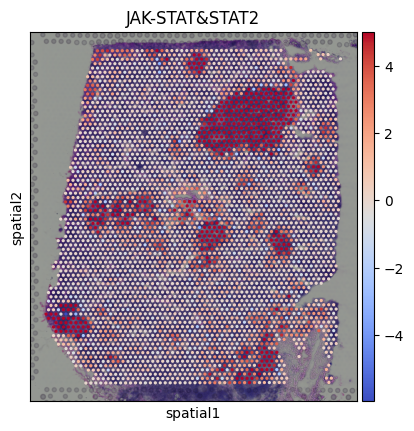

In [112]:
sc.pl.spatial(local_rs, color=['JAK-STAT&STAT2'], cmap='coolwarm', vmax=5)

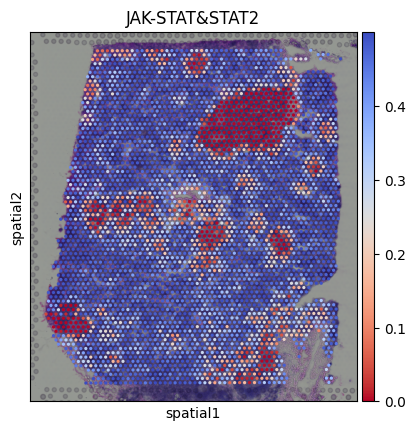

In [113]:
sc.pl.spatial(local_pvals, color=['JAK-STAT&STAT2'], cmap='coolwarm_r')

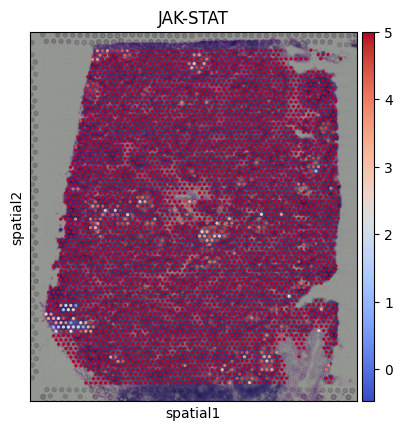

In [114]:
sc.pl.spatial(progeny, color=['JAK-STAT'], use_raw=False, cmap='coolwarm', vmax=5)

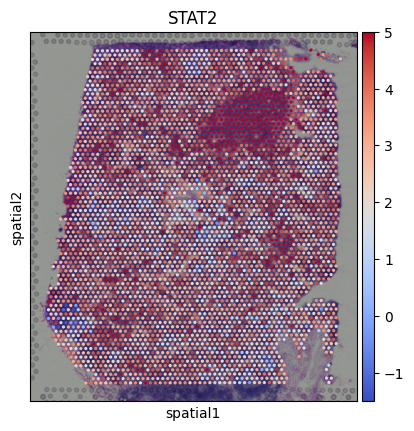

In [115]:
sc.pl.spatial(dorothea, color=['STAT2'], use_raw=False, cmap='coolwarm', vmax=5)

In [ ]:
adata

In [ ]:
sc.pl.pl

## Rework SpatialMethod

In [ ]:
import weakref
from anndata import AnnData
from pandas import DataFrame, concat
from typing import Optional

In [ ]:
# TODO MethodMeta class to generalizable, SpatialMethod & SingleCellMethod should inherit and extend
class SpatialMethod:
    """
    A SpatialMethod Class
    """

    def __init__(self,
                 method_name: str,
                 key_cols: list,  # note that this is defined here but not in Method
                 reference: str,
                 local_function: callable,
                 global_function: callable,
                 ):
        """
        Parameters
        ----------
        method_name
            Name of the Method
        key_cols
            columns which make every interaction unique (i.e. PK).
        reference
            Publication reference in Harvard style
        """
        self.method_name = method_name
        self.key_cols = key_cols
        self.reference = reference

    def describe(self):
        """Briefly described the method"""
        print(f"{ self.method_name } does XYZ")

    def reference(self):
        """Prints out reference in Harvard format"""
        print(self.reference)

    def get_meta(self):
        """Returns method metadata as pandas row"""
        meta = DataFrame([{"Method Name": self.method_name,
                           "Reference": self.reference
                           }])
        return meta


In [ ]:
## SpatialMethod Class should have the x, y matrix as input, not ligand and receptor

In [ ]:
## This should become the SpatialLRMethod class, which extends SpatialMethod
class SpatialDM(SpatialMethod):
    def __init__(self, _method, _complex_cols, _obsm_keys): # _complex_cols is only for LR
        super().__init__(method_name=_method.method_name,
                         key_cols=_method.key_cols,
                         reference=_method.reference,
                         )

        self.complex_cols = _complex_cols
        self.obsm_keys = _obsm_keys
        self._method = _method

    def __call__(self,
                 adata: AnnData,
                 resource_name: str = 'consensus',
                 expr_prop: float = 0.05,
                 pvalue_method: str = 'analytical', # to global_kwargs and local_kwargs
                 n_perm: int = 1000,
                 positive_only: bool = True,
                 use_raw: Optional[bool] = True,
                 layer: Optional[str] = None,
                 verbose: Optional[bool] = False,
                 seed: int = 1337,
                 resource: Optional[DataFrame] = None,
                 inplace=True
                 ):
        """
        Parameters
        ----------
        adata
            Annotated data object.
        resource_name
            Name of the resource to be loaded and use for ligand-receptor inference.
        expr_prop
            Minimum expression proportion for the ligands/receptors (and their subunits).
             Set to `0` to return unfiltered results.
        pvalue_method
            Method to obtain P-values: One out of ['permutation', 'analytical'];
            'analytical' by default.
        n_perm
            Number of permutations to be performed if `pvalue_method`=='permutation'
        positive_only
            Whether to calculate p-values only for positive correlations. `True` by default.
        use_raw
            Use raw attribute of adata if present.
        layer
            Layer in anndata.AnnData.layers to use. If None, use anndata.AnnData.X.
        verbose
            Verbosity flag
        seed
            Random seed for reproducibility.
        resource
            Parameter to enable external resources to be passed. Expects a pandas dataframe
            with [`ligand`, `receptor`] columns. None by default. If provided will overrule
            the resource requested via `resource_name`
        inplace
            If true return `DataFrame` with results, else assign to `.uns`.

        Returns
        -------
        If ``inplace = False``, returns:
        - 1) a `DataFrame` with ligand-receptor correlations for the whole slide (global)
        - 2) a `DataFrame` with ligand-receptor Moran's I for each spot
        - 3) a `DataFrame` with ligand-receptor correlations p-values for each spot
        Otherwise, modifies the ``adata`` object with the following keys:
        - :attr:`anndata.AnnData.uns` ``['global_res']`` with `1)`
        - :attr:`anndata.AnnData.obsm` ``['local_r']`` with  `2)`
        - :attr:`anndata.AnnData.obsm` ``['local_pvals']`` with  `3)`

        """
        assert pvalue_method in ['analytical', 'permutation']

        temp, lr_res, ligand_pos, receptor_pos = _global_lr_pipe(adata=adata,
                                                                 resource_name=resource_name,
                                                                 resource=resource,
                                                                 expr_prop=expr_prop,
                                                                 use_raw=use_raw,
                                                                 layer=layer,
                                                                 verbose=verbose,
                                                                 _key_cols=self.key_cols,
                                                                 _complex_cols=self.complex_cols,
                                                                 _obms_keys=self.obsm_keys
                                                                 )

        # n / sum(W) for Moran's I
        norm_factor = temp.obsm['proximity'].shape[0] / temp.obsm['proximity'].sum()
        dist = csr_matrix(norm_factor * temp.obsm['proximity'])

        # we use the same gene expression matrix for both x and y
        lr_res['global_r'], lr_res['global_pvals'] = \
            _global_spatialdm(x_mat=temp.X,
                              y_mat=temp.X,
                              x_pos=ligand_pos,
                              y_pos=receptor_pos,
                              xy_dataframe=lr_res,
                              dist=dist,
                              seed=seed,
                              n_perm=n_perm,
                              pvalue_method=pvalue_method,
                              positive_only=positive_only
                              )
        local_r, local_pvals = _local_spatialdm(x_mat=temp.X,
                                                y_mat=temp.X,
                                                x_pos=ligand_pos,
                                                y_pos=receptor_pos,
                                                xy_dataframe=lr_res,
                                                dist=dist,  # TODO msq?
                                                seed=seed,
                                                n_perm=n_perm,
                                                pvalue_method=pvalue_method,
                                                positive_only=positive_only
                                                )

        # convert to dataframes
        local_r = _local_to_dataframe(array=local_r,
                                      idx=temp.obs.index,
                                      columns=lr_res.interaction)
        local_pvals = _local_to_dataframe(array=local_pvals,
                                          idx=temp.obs.index,
                                          columns=lr_res.interaction)

        if inplace:
            adata.uns['global_res'] = lr_res
            adata.obsm['local_r'] = local_r
            adata.obsm['local_pvals'] = local_pvals

        return None if inplace else (lr_res, local_r, local_pvals)